Analyzing Crime Statistics for the Summer of 2014 in Seattle
============================================================

This is an exploration of (a reduced set of) public crime data in the city of Seattle during the Summer of 2014. The goal is to identify and visualize interesting patterns in this data.

The Data
--------

The data comes in the form of a CSV file, so let's load it up in [Pandas](http://pandas.pydata.org/pandas-docs/stable/) and see what we've got.

In [1]:
import pandas as pd

In [2]:
seattle_data = pd.read_csv('data/seattle_incidents_summer_2014.csv')

/Users/hank/dev/.virtualenvs/datasci_assignment_six/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Well, the first I noticed about it is that type inference is failing on column 9. Let's see what it's supposed to be.

In [3]:
seattle_data.columns

Index(['RMS CDW ID', 'General Offense Number', 'Offense Code',
       'Offense Code Extension', 'Offense Type', 'Summary Offense Code',
       'Summarized Offense Description', 'Date Reported',
       'Occurred Date or Date Range Start', 'Occurred Date Range End',
       'Hundred Block Location', 'District/Sector', 'Zone/Beat',
       'Census Tract 2000', 'Longitude', 'Latitude', 'Location', 'Month',
       'Year'],
      dtype='object')

Apparently, that's `Occurred Date Range End`. Let's take a peak and see what's in that column.

In [4]:
seattle_data['Occurred Date Range End'].head()

0    06/28/2015 10:31:00 AM
1    06/24/2015 11:09:00 AM
2                       NaN
3                       NaN
4    11/01/2014 12:00:00 PM
Name: Occurred Date Range End, dtype: object

OK, it seems like the problem is some `NaN` entries. Luckily, Pandas let's us specify different strings that mean N/A, so we'll read the file again and tell it that `NaN` is one such value.

While we're at it, let's tell Pandas to parse all these different timestamps. We'll leave it to Pandas to figure out the format, if possible.

In [5]:
seattle_data = pd.read_csv(
    'data/seattle_incidents_summer_2014.csv',  # The data file.
    na_values=['NaN'],  # 'NaN' means it's a missing value.
    parse_dates=[7,8,9],  # Columns 7-9 contain timestamps; try to parse them as such.
    infer_datetime_format=True  # I don't want to comb over all that data to figure out a format; let Pandas try.
)

# And now set up our ``DataFrame`` in dplython to make it easier to manipulate.
from dplython import DplyFrame, X, group_by, mutate, select, sift, summarize
dply_seattle = DplyFrame(seattle_data)

# Tell Jupyter we want to render these plots inline in the notebook.
%matplotlib inline
import matplotlib.pyplot as plt
# XKCD-style
# plt.xkcd()
plt.style.use("ggplot")

No warnings or errors this time, so I suspect our changes worked. Let's go ahead and peek at the data to see how it looks.

In [6]:
seattle_data.head()

,RMS CDW ID,General Offense Number,Offense Code,Offense Code Extension,Offense Type,Summary Offense Code,Summarized Offense Description,Date Reported,Occurred Date or Date Range Start,Occurred Date Range End,Hundred Block Location,District/Sector,Zone/Beat,Census Tract 2000,Longitude,Latitude,Location,Month,Year
0,483839,2015218538,2202,0,BURGLARY-FORCE-RES,2200,BURGLARY,2015-06-28 10:31:00,2014-06-28 10:31:00,2015-06-28 10:31:00,6XX BLOCK OF NW 74 ST,J,J2,2900.3013,-122.364672,47.682524,"(47.68252427, -122.364671996)",6,2014
1,481252,2015213067,2610,0,FRAUD-IDENTITY THEFT,2600,FRAUD,2015-06-24 11:09:00,2014-06-01 00:00:00,2015-06-24 11:09:00,23XX BLOCK OF 43 AV E,C,C2,6300.1004,-122.277080,47.639901,"(47.639900761, -122.277080248)",6,2014
2,481375,2015210301,2316,0,THEFT-MAIL,2300,MAIL THEFT,2015-06-22 09:22:00,2014-08-31 09:00:00,NaT,81XX BLOCK OF 11 AV SW,F,F3,11300.5013,-122.349312,47.529232,"(47.529232299, -122.349312181)",8,2014
3,481690,2015209327,2599,0,COUNTERFEIT,2500,COUNTERFEIT,2015-06-21 15:52:00,2014-06-20 13:38:00,NaT,6XX BLOCK OF PINE ST,M,M2,8200.1002,-122.334818,47.612368,"(47.612368448, -122.334817763)",6,2014
4,478198,2015207880,2399,3,THEFT-OTH,2300,OTHER PROPERTY,2015-06-20 11:59:00,2014-06-01 11:59:00,2014-11-01 12:00:00,77XX BLOCK OF SUNNYSIDE AV N,J,J3,2700.2015,-122.329379,47.685960,"(47.685959879, -122.329378505)",6,2014


That seems reasonable, so let's move on to the next step: visualizing the data and identifying patterns.

Analysis
--------

Our dataset, when augmented with some external datasets, can answer a wide range of questions. Let's choose a few for this exercise.

### Questions to Answer

1. How do incidents vary by time of day?
    1. Which incidents are most common in the evening?
    1. During what periods of the day are robberies most common?

1. How do incidents vary month to month in the Summer 2014 dataset?

1. Which incident types tend to correlate with each other on a day-by-day basis?

1. Do certain crimes correlate with temperature? NOTE: This question cannot be answered without incorporating additional data. I have reached out to a potential source of weather data, but have not yet heard back from them.

### Question 1: How does the overall incident rate vary by time of day?

To answer this question, we'll plot the total number of incidents against the time of day.  The first issue we see is the `Occurred Date or Date Range Start` column is at the wrong level of granularity to answer this question: it is actually a full date-time timestamp. We'll need to extract just the hour portion into a new column—call it `hour_of_incident`. We'll also add an `identity` column, which will just be a bunch of 1s that we sum up later.

In [7]:
import datetime

def get_hour(ts):
    return ts.hour

with_hour = (dply_seattle
    >> mutate(
        hour_of_incident = X['Occurred Date or Date Range Start'].apply(get_hour),
        identity = 1
    )
)
with_hour.head()

,RMS CDW ID,General Offense Number,Offense Code,Offense Code Extension,Offense Type,Summary Offense Code,Summarized Offense Description,Date Reported,Occurred Date or Date Range Start,Occurred Date Range End,...,District/Sector,Zone/Beat,Census Tract 2000,Longitude,Latitude,Location,Month,Year,identity,hour_of_incident
0,483839,2015218538,2202,0,BURGLARY-FORCE-RES,2200,BURGLARY,2015-06-28 10:31:00,2014-06-28 10:31:00,2015-06-28 10:31:00,...,J,J2,2900.3013,-122.364672,47.682524,"(47.68252427, -122.364671996)",6,2014,1,10
1,481252,2015213067,2610,0,FRAUD-IDENTITY THEFT,2600,FRAUD,2015-06-24 11:09:00,2014-06-01 00:00:00,2015-06-24 11:09:00,...,C,C2,6300.1004,-122.277080,47.639901,"(47.639900761, -122.277080248)",6,2014,1,0
2,481375,2015210301,2316,0,THEFT-MAIL,2300,MAIL THEFT,2015-06-22 09:22:00,2014-08-31 09:00:00,NaT,...,F,F3,11300.5013,-122.349312,47.529232,"(47.529232299, -122.349312181)",8,2014,1,9
3,481690,2015209327,2599,0,COUNTERFEIT,2500,COUNTERFEIT,2015-06-21 15:52:00,2014-06-20 13:38:00,NaT,...,M,M2,8200.1002,-122.334818,47.612368,"(47.612368448, -122.334817763)",6,2014,1,13
4,478198,2015207880,2399,3,THEFT-OTH,2300,OTHER PROPERTY,2015-06-20 11:59:00,2014-06-01 11:59:00,2014-11-01 12:00:00,...,J,J3,2700.2015,-122.329379,47.685960,"(47.685959879, -122.329378505)",6,2014,1,11


Now we have the basic info we need for plotting the data against the hour of the day. Rather than a raw "incident" count for each hour, I think it would be useful to see the different types of offenses broken out separately. A line chart would be a fairly obvious choice here, but I still want to see the total number of offenses per hour, so let's use a [stacked area plot](http://pandas.pydata.org/pandas-docs/stable/visualization.html#visualization-area-plot) instead, which is happily baked right into the `DataFrame`.

This visualization expects to find the different categories to plot as columns, so we'll need to reshape our data. Once again, the `DataFrame` has what we need: the [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/reshaping.html#pivot-tables) function.

In [8]:
hour_and_offense_counts = with_hour[["hour_of_incident", "Offense Type", "identity"]].pivot_table(
    index="hour_of_incident",  # We're going to use the hour of the offense as the index.
    columns="Offense Type",  # For each type of offense, we'll create a new column.
    values="identity",  # The value we're counting; in the raw data, this is a 1 for
                        # each offense.
    aggfunc=sum,  # We want to roll up our count of `identity` for each category, so
                  # we use the ``sum`` aggregation. If we omit this, the entire pivot
                  # operation will fail because we will have more than one row for
                  # each hour.
    dropna=False,  # We don't want to drop missing values; we'll use a "filler" value instead.
    fill_value=0  # 0, to be precise.
)
hour_and_offense_counts.head()

Offense Type,ANIMAL-BITE,ANIMAL-CRUELTY,ANIMAL-OTH,ASSLT-AGG-BODYFORCE,ASSLT-AGG-GUN,ASSLT-AGG-POLICE-BODYFORCE,ASSLT-AGG-POLICE-GUN,ASSLT-AGG-POLICE-WEAPON,ASSLT-AGG-WEAPON,ASSLT-NONAGG,...,WARRANT-FUGITIVE,WARRARR-FELONY,WARRARR-MISDEMEANOR,WEAPON-CONCEALED,WEAPON-DISCHARGE,WEAPON-POSSESSION,WEAPON-SELLING,WEAPON-SURRENDER-EXCLUDING FIR,WEAPON-UNLAWFUL USE,[INC - CASE DC USE ONLY]
hour_of_incident,,,,,,,,,,,,,,,,,,,,,
0,2,2,5,7,6,0,0,0,21,53,...,2,18,16,0,6,0,0,0,0,1
1,2,0,0,19,4,0,0,0,32,53,...,0,4,13,0,8,2,0,0,0,0
2,0,0,0,16,11,0,0,4,15,73,...,0,10,4,0,2,2,0,0,2,0
3,2,0,1,0,2,0,0,0,10,19,...,0,5,4,0,1,2,0,0,0,0
4,0,0,0,0,0,0,0,0,8,22,...,0,0,5,0,0,0,0,0,0,0


Hmm… that's a **lot** of columns. I think we're going to need to pare down our categories a bit. This is going to be a *very* rough cut at this, because doing a good job would likely require a detailed analysis of the coding system used to build the source data, and I don't have that information. 

From a cursory glance at the data, I can see that there are multiple types of offense for assaults, weapons charges, etc., so let's try to consolidate similar types of offense. Each of those "super categories" appears to be broken down using the following scheme: TOP-SUB1-SUB2, so we can get the top-level categories by doing a simple split.

In [9]:
def extract_top_level_type(x):
    return x.split('-')[0]

full_partly_consolidated_with_hour = (with_hour
    >> mutate(
        consolidated_offense = X['Offense Type'].apply(extract_top_level_type)
    )
)

OK, let's see how many categories we're looking at after the consolidation.

In [10]:
full_partly_consolidated_with_hour.consolidated_offense.nunique()

51

51 is still too many, so let's try something a bit more… extensive.

According to [this LegalMatch article](http://www.legalmatch.com/law-library/article/what-are-the-different-types-of-crimes.html), crimes are generally divided into the following categories:

<dl>
  <dt>Personal Crimes</dt><dd>crimes that result in physical or mental harm to another person, e.g., assault</dd>
  <dt>Property Crimes</dt><dd>crimes that do not necessarily involve harm to another person, instead involving an interference with another person’s right to use or enjoy their property, e.g., burglary</dd>
  <dt>Inchoate Crimes</dt><dd>crimes that were begun, but not completed, e.g., solicitation. This requires that a person take a substantial step to complete a crime, as opposed to just “intend” to commit a crime.</dd>
  <dt>Statutory Crimes</dt><dd>a violation of a specific state or federal statute and can involve either property offenses or personal offense, e.g., DUI.</dd>
</dl>

I have manually mapped each of the `Offense Type` entries back to these 4 categories, although based on my rudimentary undertanding, none of them actually qualified as "Inchoate", and some would have fit under either "Personal" or "Property", e.g, all of the `ROBBERY-…` entries.

In [11]:
_personal = set([
    'ASSLT-AGG-BODYFORCE',
    'ASSLT-AGG-GUN',
    'ASSLT-AGG-POLICE-BODYFORCE',
    'ASSLT-AGG-POLICE-GUN',
    'ASSLT-AGG-POLICE-WEAPON',
    'ASSLT-AGG-WEAPON',
    'ASSLT-NONAGG',
    'ASSLT-NONAGG-POLICE',
    'DISPUTE-OTH',
    'ENDANGERMENT',
    'HARASSMENT',
    'HOMICIDE-JUST-GUN',
    'HOMICIDE-JUST-WEAPON',
    'HOMICIDE-PREMEDITATED-GUN',
    'INJURY - ACCIDENTAL',
    'INJURY - OTHER',
    'MALICIOUS HARASSMENT',
    'ROBBERY-BANK-BODYFORCE',
    'ROBBERY-BANK-GUN',
    'ROBBERY-BANK-WEAPON',
    'ROBBERY-BUSINESS-BODYFORCE',
    'ROBBERY-BUSINESS-GUN',
    'ROBBERY-BUSINESS-WEAPON',
    'ROBBERY-RESIDENCE-BODYFORCE',
    'ROBBERY-RESIDENCE-GUN',
    'ROBBERY-RESIDENCE-WEAPON',
    'ROBBERY-STREET-BODYFORCE',
    'ROBBERY-STREET-GUN',
    'ROBBERY-STREET-WEAPON',
    'THREATS-KILL',
    'THREATS-OTHER',
    'THREATS-WEAPON',
])
_property = set([
    'BURGLARY-FORCE-NONRES',
    'BURGLARY-FORCE-RES',
    'BURGLARY-NOFORCE-NONRES',
    'BURGLARY-NOFORCE-RES',
    'BURGLARY-SECURE PARKING-NONRES',
    'BURGLARY-SECURE PARKING-RES',
    'COUNTERFEIT',
    'DISPUTE-CIVIL PROPERTY (AUTO)',
    'DISPUTE-CIVIL PROPERTY (NON AU',
    'EMBEZZLE',
    'FORGERY-CHECK',
    'FORGERY-CREDIT CARD',
    'FORGERY-OTH',
    'FRAUD-CHECK',
    'FRAUD-COMPUTER',
    'FRAUD-CREDIT CARD',
    'FRAUD-IDENTITY THEFT',
    'FRAUD-OTHER',
    'FRAUD-WIRE-ELECTRONIC',
    'PROP RECOVERED-OTHER AGENCY',
    'PROPERTY DAMAGE - GRAFFITI',
    'PROPERTY DAMAGE-NON RESIDENTIA',
    'PROPERTY DAMAGE-RESIDENTIAL',
    'PROPERTY FOUND',
    'PROPERTY LOST',
    'PROPERTY LOST - POLICE EQUIPME',
    'PROPERTY STOLEN-POSSESS',
    'PROPERTY STOLEN-SELL',
    'PROPERTY STOLEN-TRAFFICKING',
    'RECKLESS BURNING',
    'THEFT OF SERVICES',
    'THEFT-AUTO PARTS',
    'THEFT-AUTOACC',
    'THEFT-BICYCLE',
    'THEFT-BOAT',
    'THEFT-BUILDING',
    'THEFT-CARPROWL',
    'THEFT-COINOP',
    'THEFT-LICENSE PLATE',
    'THEFT-MAIL',
    'THEFT-OTH',
    'THEFT-PKPOCKET',
    'THEFT-PRSNATCH',
    'THEFT-SHOPLIFT',
    'TRESPASS',
    'VEH-RCVD-FOR OTHER AGENCY',
    'VEH-THEFT-AUTO',
    'VEH-THEFT-MTRCYCLE',
    'VEH-THEFT-OTHVEH',
    'VEH-THEFT-TRAILER',
    'VEH-THEFT-TRUCK',
])
_inchoate = set()
_statutory = set([
    'ANIMAL-BITE',
    'ANIMAL-CRUELTY',
    'ANIMAL-OTH',
    'BIAS INCIDENT',
    'DISORDERLY CONDUCT',
    'DISTURBANCE-NOISE',
    'DISTURBANCE-OTH',
    'DRIVE-BY',
    'DUI-DRUGS',
    'DUI-LIQUOR',
    'ELUDING-FELONY FLIGHT',
    'ESCAPE',
    'FALSE REPORT',
    'FIREWORK-POSSESS',
    'FIREWORK-USE',
    'ILLEGAL DUMPING',
    'LIQUOR LAW VIOLATION',
    'NARC-DRUG TRAFFIC LOITERING',
    'NARC-EQUIPMENT/PARAPHENALIA',
    'NARC-FORGERY-PRESCRIPTION',
    'NARC-FOUND-AMPHETAMINE',
    'NARC-FOUND-COCAINE',
    'NARC-FOUND-HEROIN',
    'NARC-FOUND-MARIJU',
    'NARC-FOUND-METH',
    'NARC-FOUND-OPIUM',
    'NARC-FOUND-OTHER',
    'NARC-FOUND-SYNTHETIC',
    'NARC-FRAUD-PRESCRIPTION',
    'NARC-POSSESS-AMPHETAMINE',
    'NARC-POSSESS-COCAINE',
    'NARC-POSSESS-HALLUCINOGEN',
    'NARC-POSSESS-HEROIN',
    'NARC-POSSESS-MARIJU',
    'NARC-POSSESS-METH',
    'NARC-POSSESS-OTHER',
    'NARC-POSSESS-PILL/TABLET',
    'NARC-PRODUCE-MARIJU',
    'NARC-SELL-AMPHETAMINE',
    'NARC-SELL-COCAINE',
    'NARC-SELL-HEROIN',
    'NARC-SELL-MARIJU',
    'NARC-SELL-METH',
    'NARC-SELL-SYNTHETIC',
    'NARC-SMUGGLE-OTHER',
    'OBSTRUCT',
    'PORNOGRAPHY-OBSCENE MATERIAL',
    'PROSTITUTION',
    'PROSTITUTION LOITERING',
    'PROSTITUTION PATRONIZING',
    'PROSTITUTION-ASSIST-PROMOTE',
    'TRAFFIC',
    'URINATING/DEFECATING-IN PUBLIC',
    'VIOL-COURT ORDER',
    'WARRANT-FUGITIVE',
    'WARRARR-FELONY',
    'WARRARR-MISDEMEANOR',
    'WEAPON-CONCEALED',
    'WEAPON-DISCHARGE',
    'WEAPON-POSSESSION',
    'WEAPON-SELLING',
    'WEAPON-SURRENDER-EXCLUDING FIR',
    'WEAPON-UNLAWFUL USE',
    '[INC - CASE DC USE ONLY]'
])

def map_offense_type_to_category(ot):
    if ot in _personal:
        return "PERSONAL"
    if ot in _property:
        return "PROPERTY"
    if ot in _inchoate:
        return "INCHOATE"
    if ot in _statutory:
        return "STATUTORY"
    return None

full_consolidated_with_hour = (with_hour
    >> mutate(
        consolidated_offense = X['Offense Type'].apply(map_offense_type_to_category)
    )
)
consolidated_with_hour = (full_consolidated_with_hour
    >> select(X.hour_of_incident, X.consolidated_offense, X.identity)
)

OK, let's see how many categories we're looking at after *this* consolidation (it should be 3).

In [12]:
consolidated_with_hour.consolidated_offense.nunique()

3

3 is the answer we were looking for, so let's do an area plot now.

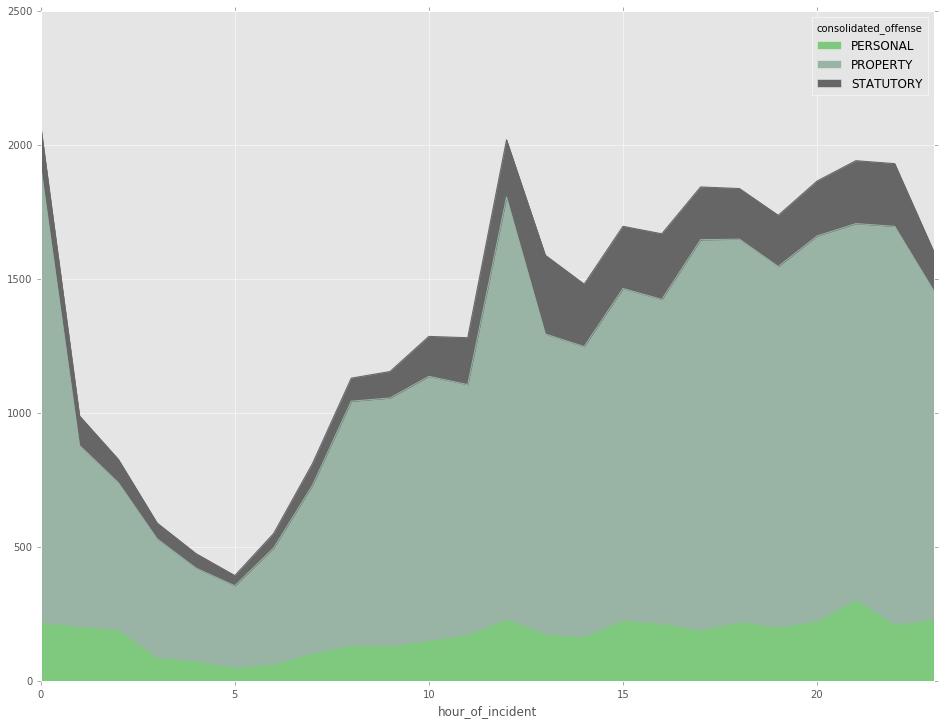

In [13]:
hour_and_offense_counts = consolidated_with_hour.pivot_table(
    index="hour_of_incident",  # We're going to use the date of the offense as the index.
    columns="consolidated_offense",  # For each type of offense, we'll create a new column.
    values="identity",  # The value we're counting; in the raw data, this is a 1 for
                        # each offense.
    aggfunc=sum,  # We want to roll up our count of `identity` for each category, so
                  # we use the ``sum`` aggregation. If we omit this, the entire pivot
                  # operation will fail because we will have more than one row for
                  # each date.
    dropna=False,  # We don't want to drop missing values; we'll use a "filler" value instead.
    fill_value=0  # 0, to be precise.
)
hour_and_offense_counts.plot.area(figsize=(16,12), colormap='Accent')

It would appear that criminals have the same basic sleep patterns as society at large: there is a *significant* drop in the number of crimes committed once we get past midnight, bottoming out at 5AM. By about 8AM, the number of incidents is back up to approximately 1AM levels. A spike at noon is followed by a short dip (food coma?) and then slowly rises throughout the afternoon/evening, with peak criminal activity coming in the midnight hour. At all hours, property crimes are by far the most numerous type of crime.

### Question 2: How do incidents vary month to month in the Summer 2014 dataset.

To answer this question, we'll start by plotting the total number of incidents by date over the full dataset. Again, we see `Occurred Date or Date Range Start` is at the wrong level of granularity to answer this question: this time we need just the date portion. Let's add another new column: `date_of_incident` (the date we'll use to group offenses). We'll just add this column to the consolidated version of the table, so we don't have to do all that classification again.

In [14]:
def get_date(ts):
    return ts.date()

full_consolidated_with_date = (full_consolidated_with_hour
    >> mutate(
        date_of_incident = X['Occurred Date or Date Range Start'].apply(get_date)
    )
)
consolidated_with_date = (full_consolidated_with_date
    >> select(X.date_of_incident, X.consolidated_offense, X.identity)
)

Now we have the basic info we need for plotting the data as a date-series. Similar to our approach in Question 1, I'd like to break things down by the type of crime, so let's use the same type of visualization.

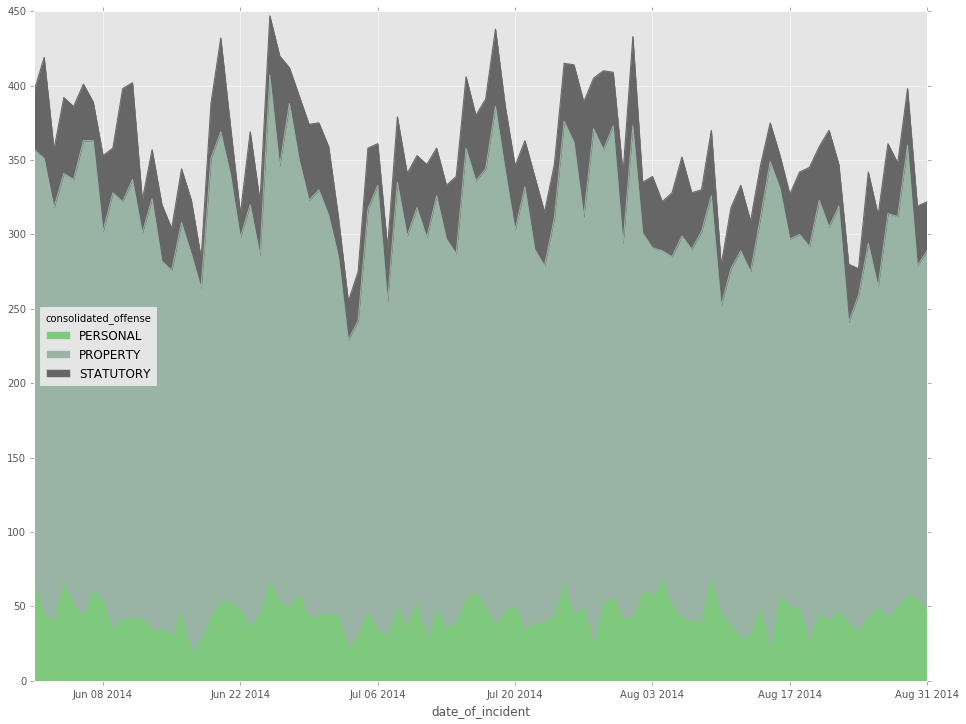

In [15]:
date_and_offense_counts = consolidated_with_date.pivot_table(
    index="date_of_incident",  # We're going to use the date of the offense as the index.
    columns="consolidated_offense",  # For each type of offense, we'll create a new column.
    values="identity",  # The value we're counting; in the raw data, this is a 1 for
                        # each offense.
    aggfunc=sum,  # We want to roll up our count of `identity` for each category, so
                  # we use the ``sum`` aggregation. If we omit this, the entire pivot
                  # operation will fail because we will have more than one row for
                  # each date.
    dropna=False,  # We don't want to drop missing values; we'll use a "filler" value instead.
    fill_value=0  # 0, to be precise.
)
date_and_offense_counts.plot.area(figsize=(16,12), colormap='Accent')

We can see that the overall crime rate begins to drop off in August. Once again, property crimes dominate the overall crime rate. Whereas the curve for the number of crimes per hour is fairly smooth, the change from one day to the next is much more pronounced.

### Question 3: Which incident types tend to correlate with each other on a day-by-day basis?

Correlations are usually very easy to spot with a line plot, and line plots can support quite a few more categories than an area plot, so let's use our first version of the consolidated offense data, but modified to ignore offense types that don't average at least 10 offenses per day. That should reduce a lot of the noise coming from small sample sizes.

In [16]:
full_partly_consolidated_with_date = (full_partly_consolidated_with_hour
    >> mutate(
        date_of_incident = X['Occurred Date or Date Range Start'].apply(get_date)
    )
)

days_in_dataset = len(full_partly_consolidated_with_date.date_of_incident.unique())
small_samples = set((full_partly_consolidated_with_date
    >> group_by(X.consolidated_offense)
    >> summarize(avg_offenses=X.consolidated_offense.count()/days_in_dataset)
    >> sift(X.avg_offenses < 10)
).consolidated_offense)
len(small_samples)

42

It looks like removing the extremely uncommon offenses will drop us down to 16 types of offense. Let's see if that is few enough to let us visualize it effectively.

In [17]:
common_consolidated_with_date = (full_partly_consolidated_with_date
    >> sift(~X.consolidated_offense.isin(small_samples))
    >> select(X.date_of_incident, X.consolidated_offense, X.identity)
)

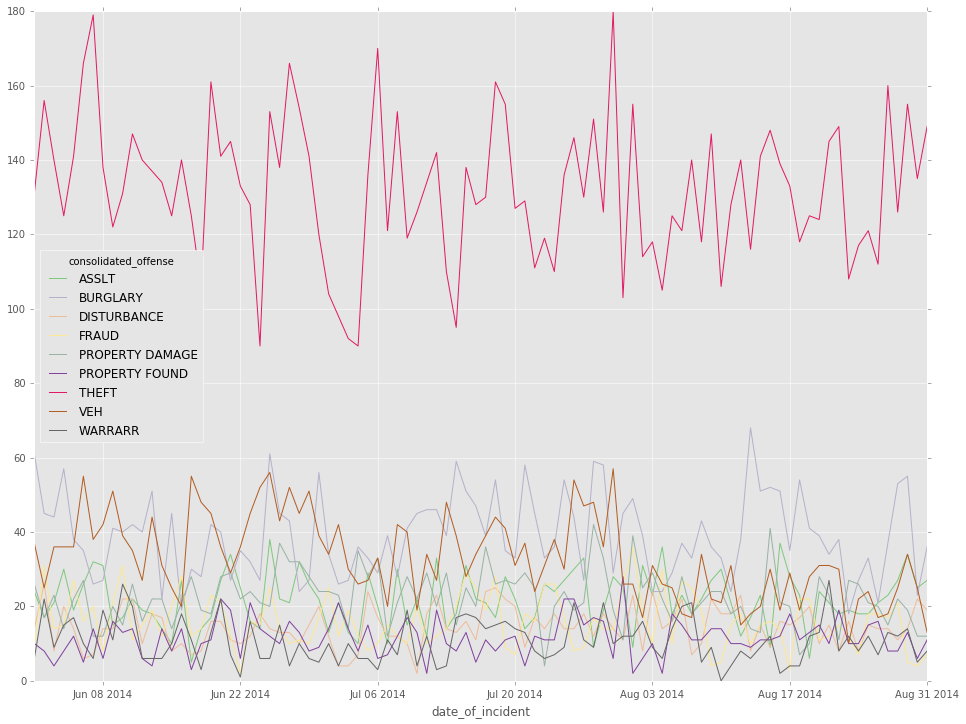

In [18]:
date_and_offense_counts = common_consolidated_with_date.pivot_table(
    index="date_of_incident",  # We're going to use the date of the offense as the index.
    columns="consolidated_offense",  # For each type of offense, we'll create a new column.
    values="identity",  # The value we're counting; in the raw data, this is a 1 for
                        # each offense.
    aggfunc=sum,  # We want to roll up our count of `identity` for each category, so
                  # we use the ``sum`` aggregation. If we omit this, the entire pivot
                  # operation will fail because we will have more than one row for
                  # each date.
    dropna=False,  # We don't want to drop missing values; we'll use a "filler" value instead.
    fill_value=0  # 0, to be precise.
)
date_and_offense_counts.plot.line(figsize=(16,12), colormap='Accent')

There seems to be a very rough correlation between most types of offenses, but this doesn't make it exceptionally clear which are strongest. Let's try calculating the correlation coefficients for the various offenses and plotting *that*.

In [19]:
extended_date_and_offense_counts = common_consolidated_with_date.pivot_table(
    index="date_of_incident",  # We're going to use the date of the offense as the index.
    columns="consolidated_offense",  # For each type of offense, we'll create a new column.
    values="identity",  # The value we're counting; in the raw data, this is a 1 for
                        # each offense.
    aggfunc=sum,  # We want to roll up our count of `identity` for each category, so
                  # we use the ``sum`` aggregation. If we omit this, the entire pivot
                  # operation will fail because we will have more than one row for
                  # each date.
    dropna=False,  # We don't want to drop missing values; we'll use a "filler" value instead.
    fill_value=0  # 0, to be precise.
)
correlations = extended_date_and_offense_counts.corr()

Now we have the correlation matrix, but it actually duplicates all the pairwise data. We will manually generate the possible pairs (paying no attention to order) using [`itertools.combinations`](https://docs.python.org/3/library/itertools.html?highlight=itertools#itertools.combinations), use them to pull out the deduplicated data into a [`Series`](http://pandas.pydata.org/pandas-docs/stable/dsintro.html?highlight=series#series), and plot that.

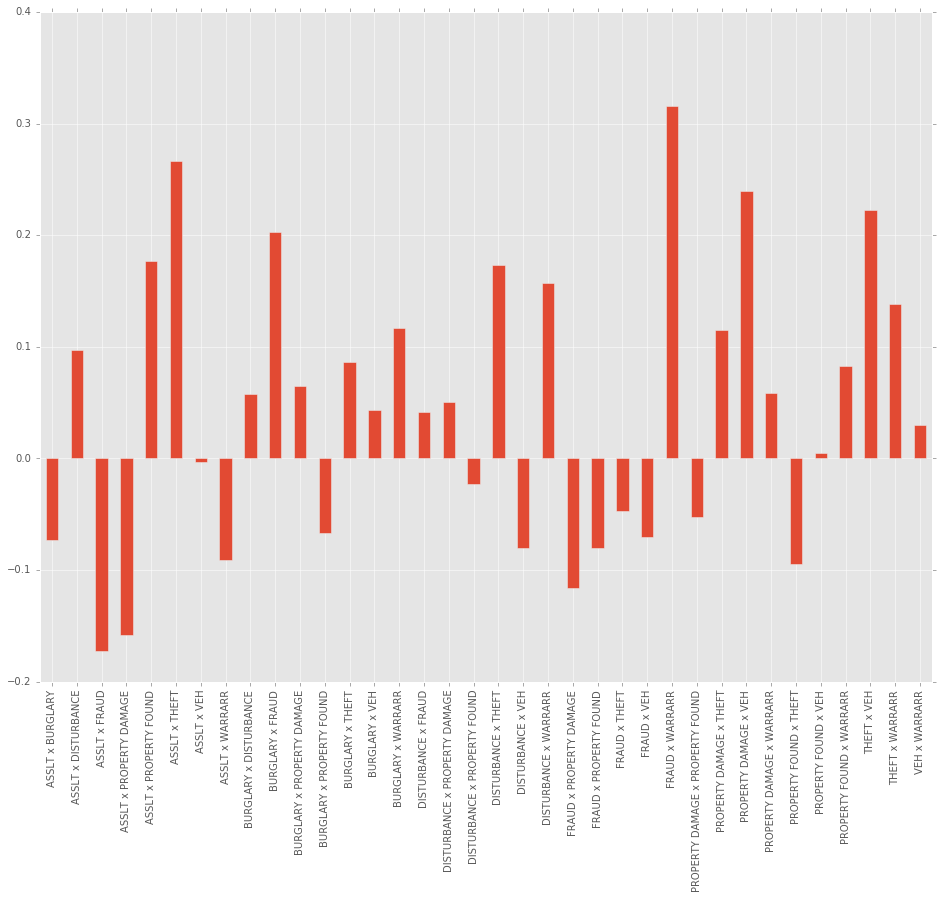

In [20]:
import itertools
pairs = itertools.combinations(correlations.columns, 2)
correlations_series = pd.Series({
    "{} x {}".format(pair[0], pair[1]): correlations[pair[0]][pair[1]] for pair in pairs
})
correlations_series.plot.bar(figsize=(16,12))

Among the most common offense types, only the following pairs had a correlation coefficient > .25:

* `ASSLT` & `THEFT`
* `FRAUD` & `WARRARR`

It would appear that the various peaks/troughs that lined up in our earlier graph mislead us into seeing a stronger correlation than actually existed over the full dataset.

### Question 4: Do certain crimes correlate with temperature?